<a href="https://colab.research.google.com/github/eggtgg/bt_minhtriho_all/blob/main/nlp-doan/nlp_them_dau_tieng_viet_transformer_nhom5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Thêm Dấu Văn Bản tiếng Việt Transformer
**Nhóm 5**

**Thành viên**
* Hồ Minh Trí
* Nguyễn Tiến Thịnh
* Tôn Thất Bảo Văn

**Giảng viên hướng dẫn**: Đoàn Thị Hông Phước

## Khởi tạo các Lớp

In [ ]:
# @title Tạo class Multi Head Attention biểu diễn các lớp Head Attention
import torch
import torch.nn as nn
import math


class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_dim=256, num_heads=4):
        """
        input_dim: Dimensionality of the input.
        num_heads: The number of attention heads to split the input into.
        """
        super(MultiHeadAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        assert hidden_dim % num_heads == 0, "Hidden dim must be divisible by num heads"
        self.Wv = nn.Linear(hidden_dim, hidden_dim, bias=False) # the Value part
        self.Wk = nn.Linear(hidden_dim, hidden_dim, bias=False) # the Key part
        self.Wq = nn.Linear(hidden_dim, hidden_dim, bias=False) # the Query part
        self.Wo = nn.Linear(hidden_dim, hidden_dim, bias=False) # the output layer


    def check_sdpa_inputs(self, x):
        assert x.size(1) == self.num_heads, f"Expected size of x to be ({-1, self.num_heads, -1, self.hidden_dim // self.num_heads}), got {x.size()}"
        assert x.size(3) == self.hidden_dim // self.num_heads


    def scaled_dot_product_attention(
            self,
            query,
            key,
            value,
            attention_mask=None,
            key_padding_mask=None):
        """
        query : tensor of shape (batch_size, num_heads, query_sequence_length, hidden_dim//num_heads)
        key : tensor of shape (batch_size, num_heads, key_sequence_length, hidden_dim//num_heads)
        value : tensor of shape (batch_size, num_heads, key_sequence_length, hidden_dim//num_heads)
        attention_mask : tensor of shape (query_sequence_length, key_sequence_length)
        key_padding_mask : tensor of shape (sequence_length, key_sequence_length)


        """
        self.check_sdpa_inputs(query)
        self.check_sdpa_inputs(key)
        self.check_sdpa_inputs(value)


        d_k = query.size(-1)
        tgt_len, src_len = query.size(-2), key.size(-2)


        # logits = (B, H, tgt_len, E) * (B, H, E, src_len) = (B, H, tgt_len, src_len)
        logits = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)

        # Attention mask here
        if attention_mask is not None:
            if attention_mask.dim() == 2:
                assert attention_mask.size() == (tgt_len, src_len)
                attention_mask = attention_mask.unsqueeze(0)
                logits = logits + attention_mask
            else:
                raise ValueError(f"Attention mask size {attention_mask.size()}")


        # Key mask here
        if key_padding_mask is not None:
            key_padding_mask = key_padding_mask.unsqueeze(1).unsqueeze(2) # Broadcast over batch size, num heads
            logits = logits + key_padding_mask


        attention = torch.softmax(logits, dim=-1)
        output = torch.matmul(attention, value) # (batch_size, num_heads, sequence_length, hidden_dim)

        return output, attention


    def split_into_heads(self, x, num_heads):
        batch_size, seq_length, hidden_dim = x.size()
        x = x.view(batch_size, seq_length, num_heads, hidden_dim // num_heads)

        return x.transpose(1, 2) # Final dim will be (batch_size, num_heads, seq_length, , hidden_dim // num_heads)

    def combine_heads(self, x):
        batch_size, num_heads, seq_length, head_hidden_dim = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, num_heads * head_hidden_dim)


    def forward(
            self,
            q,
            k,
            v,
            attention_mask=None,
            key_padding_mask=None):
        """
        q : tensor of shape (batch_size, query_sequence_length, hidden_dim)
        k : tensor of shape (batch_size, key_sequence_length, hidden_dim)
        v : tensor of shape (batch_size, key_sequence_length, hidden_dim)
        attention_mask : tensor of shape (query_sequence_length, key_sequence_length)
        key_padding_mask : tensor of shape (sequence_length, key_sequence_length)

        """
        q = self.Wq(q)
        k = self.Wk(k)
        v = self.Wv(v)

        q = self.split_into_heads(q, self.num_heads)
        k = self.split_into_heads(k, self.num_heads)
        v = self.split_into_heads(v, self.num_heads)

        # attn_values, attn_weights = self.multihead_attn(q, k, v, attn_mask=attention_mask)
        attn_values, attn_weights  = self.scaled_dot_product_attention(
            query=q,
            key=k,
            value=v,
            attention_mask=attention_mask,
            key_padding_mask=key_padding_mask,
        )
        grouped = self.combine_heads(attn_values)
        output = self.Wo(grouped)

        self.attention_weigths = attn_weights

        return output

In [ ]:
# @title Tạo class Positional Encoding, biểu diễn sự tương quan vị trí giữa các Token
# Taken from https://pytorch.org/tutorials/beginner/transformer_tutorial.html#define-the-model
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:, :x.size(1), :]
        return x

In [ ]:
# @title Tạo class PositionWiseFeedForward
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [ ]:
# @title Một khối Encoder
class EncoderBlock(nn.Module):
    def __init__(self, n_dim: int, dropout: float, n_heads: int):
        super(EncoderBlock, self).__init__()
        self.mha = MultiHeadAttention(hidden_dim=n_dim, num_heads=n_heads)
        self.norm1 = nn.LayerNorm(n_dim)
        self.ff = PositionWiseFeedForward(n_dim, n_dim)
        self.norm2 = nn.LayerNorm(n_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, src_padding_mask=None):
        assert x.ndim==3, "Expected input to be 3-dim, got {}".format(x.ndim)
        att_output = self.mha(x, x, x, key_padding_mask=src_padding_mask)
        x = x + self.dropout(self.norm1(att_output))

        ff_output = self.ff(x)
        output = x + self.norm2(ff_output)

        return output

In [ ]:
# @title Một class Encoder, có thể bao gồm nhiều khối Encoder
class Encoder(nn.Module):
    def __init__(
            self,
            vocab_size: int,
            n_dim: int,
            dropout: float,
            n_encoder_blocks: int,
            n_heads: int):

        super(Encoder, self).__init__()
        self.n_dim = n_dim

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=n_dim
        )
        self.positional_encoding = PositionalEncoding(
            d_model=n_dim,
            dropout=dropout
        )
        self.encoder_blocks = nn.ModuleList([
            EncoderBlock(n_dim, dropout, n_heads) for _ in range(n_encoder_blocks)
        ])


    def forward(self, x, padding_mask=None):
        x = self.embedding(x) * math.sqrt(self.n_dim)
        x = self.positional_encoding(x)
        for block in self.encoder_blocks:
            x = block(x=x, src_padding_mask=padding_mask)
        return x

In [ ]:
# @title Một khối Decoder, và một class Decoder
class DecoderBlock(nn.Module):
    def __init__(self, n_dim: int, dropout: float, n_heads: int):
        super(DecoderBlock, self).__init__()

        # The first Multi-Head Attention has a mask to avoid looking at the future
        self.self_attention = MultiHeadAttention(hidden_dim=n_dim, num_heads=n_heads)
        self.norm1 = nn.LayerNorm(n_dim)

        # The second Multi-Head Attention will take inputs from the encoder as key/value inputs
        self.cross_attention = MultiHeadAttention(hidden_dim=n_dim, num_heads=n_heads)
        self.norm2 = nn.LayerNorm(n_dim)

        self.ff = PositionWiseFeedForward(n_dim, n_dim)
        self.norm3 = nn.LayerNorm(n_dim)
        # self.dropout = nn.Dropout(dropout)


    def forward(self, tgt, memory, tgt_mask=None, tgt_padding_mask=None, memory_padding_mask=None):

        masked_att_output = self.self_attention(
            q=tgt, k=tgt, v=tgt, attention_mask=tgt_mask, key_padding_mask=tgt_padding_mask)
        x1 = tgt + self.norm1(masked_att_output)

        cross_att_output = self.cross_attention(
            q=x1, k=memory, v=memory, attention_mask=None, key_padding_mask=memory_padding_mask)
        x2 = x1 + self.norm2(cross_att_output)

        ff_output = self.ff(x2)
        output = x2 + self.norm3(ff_output)


        return output

class Decoder(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        n_dim: int,
        dropout: float,
        n_decoder_blocks: int,
        n_heads: int):

        super(Decoder, self).__init__()

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=n_dim,
            padding_idx=0
        )
        self.positional_encoding = PositionalEncoding(
            d_model=n_dim,
            dropout=dropout
        )

        self.decoder_blocks = nn.ModuleList([
            DecoderBlock(n_dim, dropout, n_heads) for _ in range(n_decoder_blocks)
        ])


    def forward(self, tgt, memory, tgt_mask=None, tgt_padding_mask=None, memory_padding_mask=None):
        x = self.embedding(tgt)
        x = self.positional_encoding(x)

        for block in self.decoder_blocks:
            x = block(
                x,
                memory,
                tgt_mask=tgt_mask,
                tgt_padding_mask=tgt_padding_mask,
                memory_padding_mask=memory_padding_mask)
        return x

In [ ]:
# @title Kết hợp encoder, decoder,... để trở thành class Transformer
import torch
import torch.nn as nn
import math


class Transformer(nn.Module):
    def __init__(self, **kwargs):
        super(Transformer, self).__init__()

        for k, v in kwargs.items():
            print(f" * {k}={v}")

        self.vocab_size = kwargs.get('vocab_size')
        self.model_dim = kwargs.get('model_dim')
        self.dropout = kwargs.get('dropout')
        self.n_encoder_layers = kwargs.get('n_encoder_layers')
        self.n_decoder_layers = kwargs.get('n_decoder_layers')
        self.n_heads = kwargs.get('n_heads')
        self.batch_size = kwargs.get('batch_size')
        self.PAD_IDX = kwargs.get('pad_idx', 0)

        self.encoder = Encoder(
            self.vocab_size, self.model_dim, self.dropout, self.n_encoder_layers, self.n_heads)
        self.decoder = Decoder(
            self.vocab_size, self.model_dim, self.dropout, self.n_decoder_layers, self.n_heads)
        self.fc = nn.Linear(self.model_dim, self.vocab_size)


    @staticmethod
    def generate_square_subsequent_mask(size: int):
            """Generate a triangular (size, size) mask. From PyTorch docs."""
            mask = (1 - torch.triu(torch.ones(size, size), diagonal=1)).bool()
            mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
            return mask


    def encode(
            self,
            x: torch.Tensor,
        ) -> torch.Tensor:
        """
        Input
            x: (B, S) with elements in (0, C) where C is num_classes
        Output
            (B, S, E) embedding
        """

        mask = (x == self.PAD_IDX).float()
        encoder_padding_mask = mask.masked_fill(mask == 1, float('-inf'))

        # (B, S, E)
        encoder_output = self.encoder(
            x,
            padding_mask=encoder_padding_mask
        )

        return encoder_output, encoder_padding_mask


    def decode(
            self,
            tgt: torch.Tensor,
            memory: torch.Tensor,
            memory_padding_mask=None
        ) -> torch.Tensor:
        """
        B = Batch size
        S = Source sequence length
        L = Target sequence length
        E = Model dimension

        Input
            encoded_x: (B, S, E)
            y: (B, L) with elements in (0, C) where C is num_classes
        Output
            (B, L, C) logits
        """

        mask = (tgt == self.PAD_IDX).float()
        tgt_padding_mask = mask.masked_fill(mask == 1, float('-inf'))

        decoder_output = self.decoder(
            tgt=tgt,
            memory=memory,
            tgt_mask=self.generate_square_subsequent_mask(tgt.size(1)),
            tgt_padding_mask=tgt_padding_mask,
            memory_padding_mask=memory_padding_mask,
        )
        output = self.fc(decoder_output)  # shape (B, L, C)
        return output



    def forward(
            self,
            x: torch.Tensor,
            y: torch.Tensor,
        ) -> torch.Tensor:
        """
        Input
            x: (B, Sx) with elements in (0, C) where C is num_classes
            y: (B, Sy) with elements in (0, C) where C is num_classes
        Output
            (B, L, C) logits
        """

        # Encoder output shape (B, S, E)
        encoder_output, encoder_padding_mask = self.encode(x)

        # Decoder output shape (B, L, C)
        decoder_output = self.decode(
            tgt=y,
            memory=encoder_output,
            memory_padding_mask=encoder_padding_mask
        )

        return decoder_output

## Chuẩn bị dữ liệu

In [ ]:
# @title Từ vựng
viet_dict = {'Y': 3, 'Ỹ': 4, 'f': 5, 'ẻ': 6, '_': 7, 'ứ': 8, 'Ằ': 9, 'Ẵ': 10, 'Ậ': 11, 'Ồ': 12, 'Ũ': 13, '3': 14, 'Ắ': 15, 'K': 16, 'ổ': 17, '0': 18, 'Ù': 19, '&': 20, 'Ủ': 21, 'Ú': 22, 'Ề': 23, 'ễ': 24, 'y': 25, 'Ê': 26, '–': 27, 'é': 28, 'Ễ': 29, 'ể': 30, '#': 31, 'M': 32, 'ự': 33, 'É': 34, 'ẵ': 35, 'Â': 36, 'Ớ': 37, 'o': 38, 'ớ': 39, 'À': 40, 'S': 41, 'ò': 42, 'O': 43, 'Ờ': 44, 'ờ': 45, 'ã': 46, 'Ỏ': 47, 'c': 48, 'r': 49, 'á': 50, '+': 51, 'Ự': 52, 'E': 53, 'ẫ': 54, 'Ỗ': 55, 'Ơ': 56, 'ẳ': 57, 'a': 58, '(': 59, 'Ộ': 60, 'd': 61, 'Ã': 62, 'q': 63, '\n': 64, 'Ó': 65, 'Ọ': 66, 'ừ': 67, 'C': 68, 'Ặ': 69, 'A': 70, 'Ử': 71, 'ô': 72, 'Ỷ': 73, 'ợ': 74, 'È': 75, 'Ầ': 76, 'ỏ': 77, '@': 78, 'g': 79, 'Ỵ': 80, 'X': 81, 'ỗ': 82, 'ỵ': 83, 'L': 84, 'Ụ': 85, 'ặ': 86, 'ấ': 87, '6': 88, ' ': 89, '}': 90, ',': 91, '9': 92, '"': 93, 'n': 94, 'ọ': 95, ':': 96, 'ị': 97, '?': 98, 'í': 99, 'è': 100, '2': 101, 'Ể': 102, 'ỉ': 103, 'Đ': 104, 'ù': 105, '%': 106, ';': 107, 'ả': 108, 'l': 109, 'Ư': 110, 'Ổ': 111, 'ạ': 112, 'ý': 113, 'Ẻ': 114, 'ệ': 115, 'Ỉ': 116, 'Ữ': 117, 'ê': 118, 'Õ': 119, 'Ò': 120, 'ắ': 121, 'k': 122, 'h': 123, '=': 124, 'Ả': 125, '[': 126, 'Ấ': 127, 'õ': 128, 'G': 129, 'ề': 130, 'ẹ': 131, 'p': 132, 'ồ': 133, '7': 134, 'ẩ': 135, "'": 136, 'Í': 137, 'Ỳ': 138, 'ầ': 139, 'Ị': 140, 'Ĩ': 141, ')': 142, 'm': 143, 'Ừ': 144, 'ụ': 145, 'ó': 146, '4': 147, 'Ế': 148, 'Ệ': 149, 'I': 150, 'w': 151, 'V': 152, 'Ố': 153, 'ở': 154, 'Ẫ': 155, '!': 156, 'ằ': 157, 'Ở': 158, '.': 159, 'Ỡ': 160, '<': 161, 'Ô': 162, 'e': 163, '>': 164, 's': 165, '\r': 166, '$': 167, 'T': 168, 'H': 169, '{': 170, 'Ẩ': 171, 'Ý': 172, 'ố': 173, 'Ẹ': 174, 'Ạ': 175, '5': 176, '1': 177, 'j': 178, 'i': 179, 'ơ': 180, 'ư': 181, 'u': 182, 'ỹ': 183, 'ỡ': 184, 'à': 185, '-': 186, 'R': 187, '\\': 188, 'z': 189, '8': 190, 'ă': 191, 'ộ': 192, 'N': 193, 'ữ': 194, 'Ợ': 195, 'ậ': 196, 'ũ': 197, 't': 198, 'Ứ': 199, 'U': 200, 'B': 201, 'ĩ': 202, '…': 203, '|': 204, '^': 205, 'ủ': 206, 'Ẽ': 207, 'ỷ': 208, ']': 209, 'Á': 210, 'x': 211, '*': 212, '/': 213, 'ỳ': 214, 'Q': 215, 'b': 216, 'ú': 217, '\t': 218, 'ử': 219, 'P': 220, 'ẽ': 221, 'Ẳ': 222, 'ế': 223, 'ì': 224, 'â': 225, 'Ì': 226, 'Ă': 227, 'đ': 228, 'D': 229, 'v': 230}

In [ ]:
# @title Hàm đảo Key-Value
def invert_dict(original_dict):
  """
  Inverts a dictionary, swapping keys and values.

  Args:
    original_dict: The original dictionary.

  Returns:
    A new dictionary with the keys and values swapped.
  """
  inverted_dict = {value: key for key, value in original_dict.items()}
  return inverted_dict

In [ ]:
r_viet_dict = invert_dict(viet_dict)

In [ ]:
# thêm Ký tự padding, ký tự bắt đầu và kết thúc
r_viet_dict[0] = "PAD"
r_viet_dict[1] = "_"
r_viet_dict[2] = "_"

In [ ]:
! pip install unidecode
! pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


In [ ]:
from unidecode import unidecode
from datasets import load_dataset

data = load_dataset("uitnlp/vietnamese_students_feedback")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/11426 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1583 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3166 [00:00<?, ? examples/s]

In [ ]:
data_labels = data["train"]["sentence"]

In [ ]:
dt_10 = data_labels[:10]

In [ ]:
for h in [list(s) for s in dt_10]:
  print(h)

['s', 'l', 'i', 'd', 'e', ' ', 'g', 'i', 'á', 'o', ' ', 't', 'r', 'ì', 'n', 'h', ' ', 'đ', 'ầ', 'y', ' ', 'đ', 'ủ', ' ', '.']
['n', 'h', 'i', 'ệ', 't', ' ', 't', 'ì', 'n', 'h', ' ', 'g', 'i', 'ả', 'n', 'g', ' ', 'd', 'ạ', 'y', ' ', ',', ' ', 'g', 'ầ', 'n', ' ', 'g', 'ũ', 'i', ' ', 'v', 'ớ', 'i', ' ', 's', 'i', 'n', 'h', ' ', 'v', 'i', 'ê', 'n', ' ', '.']
['đ', 'i', ' ', 'h', 'ọ', 'c', ' ', 'đ', 'ầ', 'y', ' ', 'đ', 'ủ', ' ', 'f', 'u', 'l', 'l', ' ', 'đ', 'i', 'ể', 'm', ' ', 'c', 'h', 'u', 'y', 'ê', 'n', ' ', 'c', 'ầ', 'n', ' ', '.']
['c', 'h', 'ư', 'a', ' ', 'á', 'p', ' ', 'd', 'ụ', 'n', 'g', ' ', 'c', 'ô', 'n', 'g', ' ', 'n', 'g', 'h', 'ệ', ' ', 't', 'h', 'ô', 'n', 'g', ' ', 't', 'i', 'n', ' ', 'v', 'à', ' ', 'c', 'á', 'c', ' ', 't', 'h', 'i', 'ế', 't', ' ', 'b', 'ị', ' ', 'h', 'ỗ', ' ', 't', 'r', 'ợ', ' ', 'c', 'h', 'o', ' ', 'v', 'i', 'ệ', 'c', ' ', 'g', 'i', 'ả', 'n', 'g', ' ', 'd', 'ạ', 'y', ' ', '.']
['t', 'h', 'ầ', 'y', ' ', 'g', 'i', 'ả', 'n', 'g', ' ', 'b', 'à', 'i', ' ', 'h', 

In [ ]:
for h in [list(s) for s in dt_10]:
  list_num = []
  for i in h:
    list_num.append(viet_dict[i])
  print(list_num)

[165, 109, 179, 61, 163, 89, 79, 179, 50, 38, 89, 198, 49, 224, 94, 123, 89, 228, 139, 25, 89, 228, 206, 89, 159]
[94, 123, 179, 115, 198, 89, 198, 224, 94, 123, 89, 79, 179, 108, 94, 79, 89, 61, 112, 25, 89, 91, 89, 79, 139, 94, 89, 79, 197, 179, 89, 230, 39, 179, 89, 165, 179, 94, 123, 89, 230, 179, 118, 94, 89, 159]
[228, 179, 89, 123, 95, 48, 89, 228, 139, 25, 89, 228, 206, 89, 5, 182, 109, 109, 89, 228, 179, 30, 143, 89, 48, 123, 182, 25, 118, 94, 89, 48, 139, 94, 89, 159]
[48, 123, 181, 58, 89, 50, 132, 89, 61, 145, 94, 79, 89, 48, 72, 94, 79, 89, 94, 79, 123, 115, 89, 198, 123, 72, 94, 79, 89, 198, 179, 94, 89, 230, 185, 89, 48, 50, 48, 89, 198, 123, 179, 223, 198, 89, 216, 97, 89, 123, 82, 89, 198, 49, 74, 89, 48, 123, 38, 89, 230, 179, 115, 48, 89, 79, 179, 108, 94, 79, 89, 61, 112, 25, 89, 159]
[198, 123, 139, 25, 89, 79, 179, 108, 94, 79, 89, 216, 185, 179, 89, 123, 58, 25, 89, 91, 89, 48, 146, 89, 94, 123, 179, 130, 182, 89, 216, 185, 179, 89, 198, 196, 132, 89, 230, 99, 89

In [ ]:
data_values = [unidecode(s) for s in data["train"]["sentence"]]
data_values_test = [unidecode(s) for s in data["test"]["sentence"]]
data_labels_test = data["test"]["sentence"]
data_labels_val = data["validation"]["sentence"]
data_values_val = [unidecode(s) for s in data["validation"]["sentence"]]

In [ ]:
data_values

['slide giao trinh day du .',
 'nhiet tinh giang day , gan gui voi sinh vien .',
 'di hoc day du full diem chuyen can .',
 'chua ap dung cong nghe thong tin va cac thiet bi ho tro cho viec giang day .',
 'thay giang bai hay , co nhieu bai tap vi du ngay tren lop .',
 'giang vien dam bao thoi gian len lop , tich cuc tra loi cau hoi cua sinh vien , thuong xuyen dat cau hoi cho sinh vien .',
 'em se no mon nay , nhung em se hoc lai o cac hoc ky ke tiep .',
 'thoi luong hoc qua dai , khong dam bao tiep thu hieu qua .',
 'noi dung mon hoc co phan thieu trong tam , hau nhu la chung chung , khai quat khien sinh vien rat kho nam duoc noi dung mon hoc .',
 'can noi ro hon bang cach trinh bay len bang thay vi nhin vao slide .',
 'thay rat tan tinh va di day rat dung gio .',
 'de bi ap luc .',
 'dang day thay wzjwz208 di qua nuoc ngoai giua chung , thay wzjwz209 day thay .',
 'mon hoc con de can nang do kho len nua .',
 'co the cho sinh vien di tham quan nhieu cong ty xem quy mo va cach lam viec 

In [ ]:
# @title Tạo class Chuẩn bị dữ liệu
import numpy as np
import torch
from torch.utils.data import Dataset


np.random.seed(0)

def generate_random_string():
    len = np.random.randint(10, 20)
    return "".join([chr(x) for x in np.random.randint(97, 97+26, len)])

class ReverseDataset(Dataset):
    def __init__(self, values, labels, pad_idx, sos_idx, eos_idx):
        super(ReverseDataset, self).__init__()
        self.pad_idx = pad_idx
        self.sos_idx = sos_idx
        self.eos_idx = eos_idx
        # self.values = [generate_random_string() for _ in range(n_samples)]
        # self.labels = [x[::-1] for x in self.values]

        self.values = values
        self.labels = labels
        print(self.values)

    def __len__(self):
        return len(self.values)  # number of samples in the dataset

    def __getitem__(self, index):
        return self.text_transform(self.values[index].rstrip("\n")), \
            self.text_transform(self.labels[index].rstrip("\n"))

    def text_transform(self, x):
        return torch.tensor([self.sos_idx] + [viet_dict[z] for z in x] + [self.eos_idx])

## Train

In [ ]:
# @title Hàm train, cập nhật
PAD_IDX = 0
SOS_IDX = 1
EOS_IDX = 2

def train(model, optimizer, loader, loss_fn, epoch):
    model.train()
    losses = 0
    acc = 0
    history_loss = []
    history_acc = []

    with tqdm(loader, position=0, leave=True) as tepoch:
        for x, y in tepoch:
            tepoch.set_description(f"Epoch {epoch}")

            optimizer.zero_grad()
            logits = model(x, y[:, :-1])
            loss = loss_fn(logits.contiguous().view(-1, model.vocab_size), y[:, 1:].contiguous().view(-1))
            loss.backward()
            optimizer.step()
            losses += loss.item()

            preds = logits.argmax(dim=-1)
            masked_pred = preds * (y[:, 1:]!=PAD_IDX)
            accuracy = (masked_pred == y[:, 1:]).float().mean()
            acc += accuracy.item()

            history_loss.append(loss.item())
            history_acc.append(accuracy.item())
            tepoch.set_postfix(loss=loss.item(), accuracy=100. * accuracy.item())

    return losses / len(list(loader)), acc / len(list(loader)), history_loss, history_acc


def evaluate(model, loader, loss_fn):
    model.eval()
    losses = 0
    acc = 0
    history_loss = []
    history_acc = []

    for x, y in tqdm(loader, position=0, leave=True):

        logits = model(x, y[:, :-1])
        loss = loss_fn(logits.contiguous().view(-1, model.vocab_size), y[:, 1:].contiguous().view(-1))
        losses += loss.item()

        preds = logits.argmax(dim=-1)
        masked_pred = preds * (y[:, 1:]!=PAD_IDX)
        accuracy = (masked_pred == y[:, 1:]).float().mean()
        acc += accuracy.item()

        history_loss.append(loss.item())
        history_acc.append(accuracy.item())

    return losses / len(list(loader)), acc / len(list(loader)), history_loss, history_acc

In [ ]:
# @title Train!!!
import torch
import time
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from mpl_toolkits.axes_grid1 import ImageGrid


def collate_fn(batch):
    """
    This function pads inputs with PAD_IDX to have batches of equal length
    """
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(src_sample)
        tgt_batch.append(tgt_sample)

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=True)
    return src_batch, tgt_batch

# Model hyperparameters
args = {
    'vocab_size': 250,
    'model_dim': 128,
    'dropout': 0.1,
    'n_encoder_layers': 1,
    'n_decoder_layers': 1,
    'n_heads': 4
}

# Define model here
model = Transformer(**args)

# Instantiate datasets
train_iter = ReverseDataset(values=data_values, labels= data_labels, pad_idx=PAD_IDX, sos_idx=SOS_IDX, eos_idx=EOS_IDX)
eval_iter = ReverseDataset(values=data_values_val, labels=data_labels_val,pad_idx=PAD_IDX, sos_idx=SOS_IDX, eos_idx=EOS_IDX)
dataloader_train = DataLoader(train_iter, batch_size=256, collate_fn=collate_fn)
dataloader_val = DataLoader(eval_iter, batch_size=256, collate_fn=collate_fn)

# During debugging, we ensure sources and targets are indeed reversed
# s, t = next(iter(dataloader_train))
# print(s[:4, ...])
# print(t[:4, ...])
# print(s.size())

# Initialize model parameters
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

# Define loss function : we ignore logits which are padding tokens
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)

# Save history to dictionnary
history = {
    'train_loss': [],
    'eval_loss': [],
    'train_acc': [],
    'eval_acc': []
}

# Main loop
for epoch in range(1, 10):
    start_time = time.time()
    train_loss, train_acc, hist_loss, hist_acc = train(model, optimizer, dataloader_train, loss_fn, epoch)
    history['train_loss'] += hist_loss
    history['train_acc'] += hist_acc
    end_time = time.time()
    val_loss, val_acc, hist_loss, hist_acc = evaluate(model, dataloader_val, loss_fn)
    history['eval_loss'] += hist_loss
    history['eval_acc'] += hist_acc
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Train acc: {train_acc:.3f}, Val loss: {val_loss:.3f}, Val acc: {val_acc:.3f} "f"Epoch time = {(end_time - start_time):.3f}s"))

 * vocab_size=250
 * model_dim=128
 * dropout=0.1
 * n_encoder_layers=1
 * n_decoder_layers=1
 * n_heads=4
['slide giao trinh day du .', 'nhiet tinh giang day , gan gui voi sinh vien .', 'di hoc day du full diem chuyen can .', 'chua ap dung cong nghe thong tin va cac thiet bi ho tro cho viec giang day .', 'thay giang bai hay , co nhieu bai tap vi du ngay tren lop .', 'giang vien dam bao thoi gian len lop , tich cuc tra loi cau hoi cua sinh vien , thuong xuyen dat cau hoi cho sinh vien .', 'em se no mon nay , nhung em se hoc lai o cac hoc ky ke tiep .', 'thoi luong hoc qua dai , khong dam bao tiep thu hieu qua .', 'noi dung mon hoc co phan thieu trong tam , hau nhu la chung chung , khai quat khien sinh vien rat kho nam duoc noi dung mon hoc .', 'can noi ro hon bang cach trinh bay len bang thay vi nhin vao slide .', 'thay rat tan tinh va di day rat dung gio .', 'de bi ap luc .', 'dang day thay wzjwz208 di qua nuoc ngoai giua chung , thay wzjwz209 day thay .', 'mon hoc con de can nang do 

100%|██████████| 7/7 [00:21<00:00,  3.13s/it]


Epoch: 1, Train loss: 3.609, Train acc: 0.830, Val loss: 3.228, Val acc: 0.848 Epoch time = 201.639s


100%|██████████| 7/7 [00:21<00:00,  3.03s/it]


Epoch: 2, Train loss: 3.028, Train acc: 0.844, Val loss: 2.610, Val acc: 0.874 Epoch time = 196.475s


100%|██████████| 7/7 [00:21<00:00,  3.10s/it]


Epoch: 3, Train loss: 2.315, Train acc: 0.871, Val loss: 2.043, Val acc: 0.889 Epoch time = 199.731s


100%|██████████| 7/7 [00:21<00:00,  3.05s/it]


Epoch: 4, Train loss: 1.885, Train acc: 0.889, Val loss: 1.635, Val acc: 0.911 Epoch time = 198.234s


100%|██████████| 7/7 [00:21<00:00,  3.01s/it]


Epoch: 5, Train loss: 1.390, Train acc: 0.919, Val loss: 1.033, Val acc: 0.944 Epoch time = 196.760s


100%|██████████| 7/7 [00:21<00:00,  3.02s/it]


Epoch: 6, Train loss: 0.830, Train acc: 0.951, Val loss: 0.537, Val acc: 0.971 Epoch time = 194.992s


100%|██████████| 7/7 [00:21<00:00,  3.08s/it]


Epoch: 7, Train loss: 0.472, Train acc: 0.971, Val loss: 0.339, Val acc: 0.980 Epoch time = 200.309s


100%|██████████| 7/7 [00:21<00:00,  3.04s/it]


Epoch: 8, Train loss: 0.326, Train acc: 0.979, Val loss: 0.267, Val acc: 0.984 Epoch time = 198.424s


100%|██████████| 7/7 [00:21<00:00,  3.05s/it]


Epoch: 9, Train loss: 0.262, Train acc: 0.983, Val loss: 0.230, Val acc: 0.986 Epoch time = 194.462s


In [ ]:
# @title Class dịch từ output về chuỗi ký tự
class Translator(nn.Module):
    def __init__(self, transformer):
        super(Translator, self).__init__()
        self.transformer = transformer

    @staticmethod
    def str_to_tokens(s):
        return [viet_dict[z] for z in s]

    @staticmethod
    def tokens_to_str(tokens):
      print(tokens[1])
      return "".join([r_viet_dict[x.item()] for x in tokens])

    def __call__(self, sentence, max_length=None, pad=False):

        x = torch.tensor(self.str_to_tokens(sentence))
        x = torch.cat([torch.tensor([SOS_IDX]), x, torch.tensor([EOS_IDX])]).unsqueeze(0)

        encoder_output, mask = self.transformer.encode(x) # (B, S, E)

        if not max_length:
            max_length = x.size(1)

        outputs = torch.ones((x.size()[0], max_length)).type_as(x).long() * SOS_IDX

        for step in range(1, max_length):
            y = outputs[:, :step]
            probs = self.transformer.decode(y, encoder_output)
            output = torch.argmax(probs, dim=-1)
            # print(f"Knowing {y} we output {output[:, -1]}")
            if output[:, -1].detach().numpy() in (EOS_IDX, SOS_IDX):
                break
            outputs[:, step] = output[:, -1]


        return self.tokens_to_str(outputs[0])

translator = Translator(model)

In [ ]:
# @title dự đoán câu đơn giản
sentence = "thay day rat hay rat thich hoc ."
print(sentence)
out = translator(sentence)
print("out: ", out)

thay day rat hay rat thich hoc .
tensor(198)
out:  _thầy dạy rất hay rất thích học ._


In [ ]:
# @title dự đoán với 100 câu đầu tiên trong tập test
list_out = []
for sentence in data_values_test[:100]:
  print(sentence)
  out = translator(sentence)
  print("out: ", out)
  list_out.append(out[1:-1])

noi tieng anh luu loat .
tensor(94)
out:  _nội tiêng ánh luu loất ._
giao vien rat vui tinh .
tensor(79)
out:  _giáo viên rất vui tình ._
co max co tam .
tensor(48)
out:  _cô mà có tậám ._
giang bai thu hut , di dom .
tensor(79)
out:  _giảng bài thu hút , đị độm ._
giao vien khong giang day kien thuc , huong dan thuc hanh trong qua trinh hoc .
tensor(79)
out:  _giáo viên không giảng dạy kiến thức , hương dẫn thức hành trong quá trình học ._
thay day nhiet tinh va tam huyet .
tensor(198)
out:  _thầy dạy nhiệt tình và tâm huyết ._
tinh diem thi dua cac nhom .
tensor(198)
out:  _tình điêm thì đưa các nhôm ._
thay nhiet tinh giang lai cho hoc sinh .
tensor(198)
out:  _thầy nhiệt tình giảng lài cho học sinh ._
co doi luc noi hoi nhanh lam sinh vien khong theo kip .
tensor(48)
out:  _cô đội lực nói hơi nhành làm sinh viên không theo kịp ._
giang day nhiet tinh , lien he thuc te kha nhieu , tuong tac voi sinh vien tuong doi tot .
tensor(79)
out:  _giảng dạy nhiệt tình , liên hể thực tế kha nh

In [ ]:
data_labels_test[:100]

['nói tiếng anh lưu loát .',
 'giáo viên rất vui tính .',
 'cô max có tâm .',
 'giảng bài thu hút , dí dỏm .',
 'giáo viên không giảng dạy kiến thức , hướng dẫn thực hành trong quá trình học .',
 'thầy dạy nhiệt tình và tâm huyết .',
 'tính điểm thi đua các nhóm .',
 'thầy nhiệt tình giảng lại cho học sinh .',
 'có đôi lúc nói hơi nhanh làm sinh viên không theo kịp .',
 'giảng dạy nhiệt tình , liên hệ thực tế khá nhiều , tương tác với sinh viên tương đối tốt .',
 'giảng viên nhiệt tình trong công tác giảng dạy .',
 'cô rất nhiệt tình , dễ thương , dạy dễ hiểu .',
 'trong trường macbook thầy số hai thì không có máy nào số một .',
 'sinh viên không tiếp thu kịp cũng như không hiểu gì .',
 'thầy nhiệt tình giúp đỡ sinh viên trong quá trình thực hành .',
 'thầy rất tận tình và giúp đỡ sinh viên rất nhiều .',
 'giảng viên giải thích kỹ và chi tiết .',
 'thầy dạy rất chi tiết , lý thuyết đầy đủ .',
 'còn những phần tìm bao đóng , chứng minh dạng chuẩn chưa làm rõ .',
 'cung cấp kiến thức bổ 

In [ ]:
data_values_test[:100]

['noi tieng anh luu loat .',
 'giao vien rat vui tinh .',
 'co max co tam .',
 'giang bai thu hut , di dom .',
 'giao vien khong giang day kien thuc , huong dan thuc hanh trong qua trinh hoc .',
 'thay day nhiet tinh va tam huyet .',
 'tinh diem thi dua cac nhom .',
 'thay nhiet tinh giang lai cho hoc sinh .',
 'co doi luc noi hoi nhanh lam sinh vien khong theo kip .',
 'giang day nhiet tinh , lien he thuc te kha nhieu , tuong tac voi sinh vien tuong doi tot .',
 'giang vien nhiet tinh trong cong tac giang day .',
 'co rat nhiet tinh , de thuong , day de hieu .',
 'trong truong macbook thay so hai thi khong co may nao so mot .',
 'sinh vien khong tiep thu kip cung nhu khong hieu gi .',
 'thay nhiet tinh giup do sinh vien trong qua trinh thuc hanh .',
 'thay rat tan tinh va giup do sinh vien rat nhieu .',
 'giang vien giai thich ky va chi tiet .',
 'thay day rat chi tiet , ly thuyet day du .',
 'con nhung phan tim bao dong , chung minh dang chuan chua lam ro .',
 'cung cap kien thuc bo 

In [ ]:
list_out

['nội tiêng ánh luu loất .',
 'giáo viên rất vui tình .',
 'cô mà có tậám .',
 'giảng bài thu hút , đị độm .',
 'giáo viên không giảng dạy kiến thức , hương dẫn thức hành trong quá trình học .',
 'thầy dạy nhiệt tình và tâm huyết .',
 'tình điêm thì đưa các nhôm .',
 'thầy nhiệt tình giảng lài cho học sinh .',
 'cô đội lực nói hơi nhành làm sinh viên không theo kịp .',
 'giảng dạy nhiệt tình , liên hể thực tế kha nhiểu , tương tậc với sinh viên tường đời tốt .',
 'giảng viên nhiệt tình trong công tậc giảng dạy .',
 'cô rất nhiệt tình , dễ thương , dạy dễ hiểu .',
 'trong trường mắcboo khấy s s hài thì không có máy nào số một .',
 'sinh viên không tiếp thứ kịp cũng như không hiểu gi .',
 'thầy nhiệt tình giúp đỡ sinh viên trong quá trình thực hành .',
 'thầy rất tận tình và giúp đỡ sinh viên rất nhiều .',
 'giảng viên giải thích kỹ và chỉ tiết .',
 'thầy dạy rất chỉ tiết , lý thuyết dạy đủ .',
 'còn những phàn tìm báo động , chưng mình đàng chưan chưa làm rõ .',
 'cung cấp kiến thức bổ 

## Kiểm thử đánh giá

In [ ]:
# @title Bleu Score theo từ, số n_gram 1->4
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Hàm để tính BLEU cho từng loại n-gram
def calculate_bleu(reference, hypothesis, n):
    weights = [1.0 / n] * n
    return sentence_bleu([reference], hypothesis, weights=weights, smoothing_function=SmoothingFunction().method1)

# Câu gốc có dấu (reference translation)
reference_translation = data_labels_test[:100]

# Kết quả từ mô hình Transformer (machine translation)
machine_translation = list_out

# Tokenize các câu
reference_tokens = [sentence.split(" ") for sentence in reference_translation]
machine_translation_tokens = [sentence.split(" ") for sentence in machine_translation]
# Tính điểm BLEU cho từng loại n-gram
unigram_bleu_scores = [
    calculate_bleu(ref, mt, 1)
    for ref, mt in zip(reference_tokens, machine_translation_tokens)
]

bigram_bleu_scores = [
    calculate_bleu(ref, mt, 2)
    for ref, mt in zip(reference_tokens, machine_translation_tokens)
]

trigram_bleu_scores = [
    calculate_bleu(ref, mt, 3)
    for ref, mt in zip(reference_tokens, machine_translation_tokens)
]

fourgram_bleu_scores = [
    calculate_bleu(ref, mt, 4)
    for ref, mt in zip(reference_tokens, machine_translation_tokens)
]

# Tính điểm BLEU trung bình cho từng loại n-gram
average_unigram_bleu = sum(unigram_bleu_scores) / len(unigram_bleu_scores)
average_bigram_bleu = sum(bigram_bleu_scores) / len(bigram_bleu_scores)
average_trigram_bleu = sum(trigram_bleu_scores) / len(trigram_bleu_scores)
average_fourgram_bleu = sum(fourgram_bleu_scores) / len(fourgram_bleu_scores)

# In ra kết quả
print(f"Average Unigram BLEU score: {average_unigram_bleu:.4f}")
print(f"Average Bigram BLEU score: {average_bigram_bleu:.4f}")
print(f"Average Trigram BLEU score: {average_trigram_bleu:.4f}")
print(f"Average Fourgram BLEU score: {average_fourgram_bleu:.4f}")

mean_bleu = np.mean([average_unigram_bleu, average_bigram_bleu, average_trigram_bleu, average_fourgram_bleu])
print(f"Mean BLEU score: {mean_bleu:.4f}")

Average Unigram BLEU score: 0.7630
Average Bigram BLEU score: 0.6586
Average Trigram BLEU score: 0.5701
Average Fourgram BLEU score: 0.4953
Mean BLEU score: 0.6217


In [ ]:
# @title Bleu Score theo ký tự, số n_gram 1->4
# Câu gốc có dấu (reference translation)
reference_translation = data_labels_test[:100]

# Kết quả từ mô hình Transformer (machine translation)
machine_translation = list_out

# Tokenize các câu
reference_tokens = [list(sentence) for sentence in reference_translation]
machine_translation_tokens = [list(sentence) for sentence in machine_translation]

# Tính điểm BLEU cho từng loại n-gram
unigram_bleu_scores = [
    calculate_bleu(ref, mt, 1)
    for ref, mt in zip(reference_tokens, machine_translation_tokens)
]

bigram_bleu_scores = [
    calculate_bleu(ref, mt, 2)
    for ref, mt in zip(reference_tokens, machine_translation_tokens)
]

trigram_bleu_scores = [
    calculate_bleu(ref, mt, 3)
    for ref, mt in zip(reference_tokens, machine_translation_tokens)
]

fourgram_bleu_scores = [
    calculate_bleu(ref, mt, 4)
    for ref, mt in zip(reference_tokens, machine_translation_tokens)
]

# Tính điểm BLEU trung bình cho từng loại n-gram
average_unigram_bleu = sum(unigram_bleu_scores) / len(unigram_bleu_scores)
average_bigram_bleu = sum(bigram_bleu_scores) / len(bigram_bleu_scores)
average_trigram_bleu = sum(trigram_bleu_scores) / len(trigram_bleu_scores)
average_fourgram_bleu = sum(fourgram_bleu_scores) / len(fourgram_bleu_scores)

# In ra kết quả
print(f"Average Unigram BLEU score: {average_unigram_bleu:.4f}")
print(f"Average Bigram BLEU score: {average_bigram_bleu:.4f}")
print(f"Average Trigram BLEU score: {average_trigram_bleu:.4f}")
print(f"Average Fourgram BLEU score: {average_fourgram_bleu:.4f}")

mean_bleu = np.mean([average_unigram_bleu, average_bigram_bleu, average_trigram_bleu, average_fourgram_bleu])
print(f"Mean BLEU score: {mean_bleu:.4f}")

Average Unigram BLEU score: 0.9364
Average Bigram BLEU score: 0.9031
Average Trigram BLEU score: 0.8700
Average Fourgram BLEU score: 0.8355
Mean BLEU score: 0.8862


<Figure size 640x480 with 0 Axes>

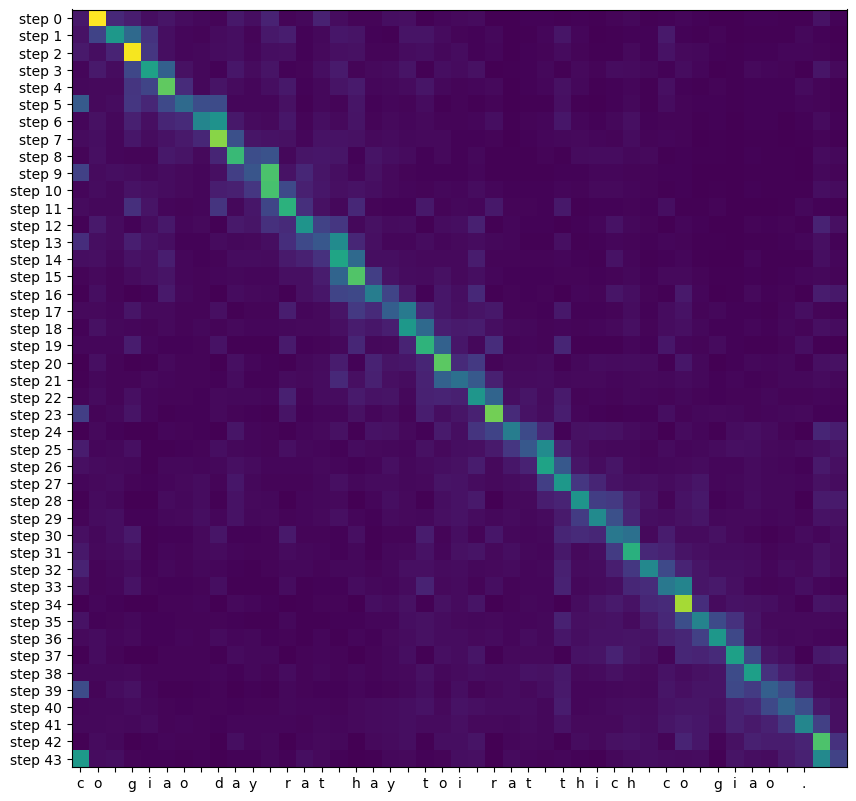

In [ ]:
fig = plt.figure()
images = model.decoder.decoder_blocks[0].cross_attention.attention_weigths[0,...].detach().numpy().mean(axis=0)

fig, ax = plt.subplots(1,1, figsize=(10., 10.))
# Iterating over the grid returs the Axes.
ax.set_yticks(range(len(out)))
ax.set_xticks(range(len(sentence)))

ax.xaxis.set_label_position('top')

ax.set_xticklabels(iter(sentence))
ax.set_yticklabels([f"step {i}" for i in range(len(out))])
ax.imshow(images)